In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import esm

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from utils.base import BaseProtein

In [4]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

In [5]:
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [11]:
protein = BaseProtein(file='../../Data/GxpS_ATC.pdb')
T = [i for i in range(538,608)] ## 539-608

In [12]:
protein.get_residues(T) ## T domain

'GEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVP'

In [19]:
masked_query = ''.join(['<mask>' if i in T else protein.sequence[i] for i in range(len(protein.sequence))])

In [20]:
masked_query

'PQQPVTAIDILSSSERELLLENWNATEEPYPTQVCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIALGVAPDQRVAICVTRSLARIIGLLAVLKAGGAYVPLDPAYPGERLAYMLTDATPVILMADNVGRAALSEDILATLTVLDPNTLLEQPDHNPQVSGLTPQHLAYVIYTSGSTGRPKGVMIEHRSVVNLTLTQITQFDVCATSRMLQFASFGFDASVWEIMMALSCGAMLVIPTETVRQDPQRLWRYLEEQAITHACLTPAMFHDGTDLPAIAIKPTLIFAGEAPSPALFQALCSRADLFNAYGPTEITVCATTWDCPADYTGGVIPIGSPVANKRLYLLDEHRQPVPLGTVGELYIGGVGVARGYLNRPELTAERFLNDPFSDETNARMYRAGDLARYLPDGNLVFVGRNDQQVKIRGFRIEPGEIEARLVEHSEVSEALVLALGDGQDKRLVAYVVALADDGLATKLREHLSDILPDYMIPAAFVRLDAFPLTPNGKLDRRSLPAPGEDAFARQAYQAPQ<mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask>HREISVPDNGITADTTVLTPAMLPLIDLTQAEIDRIVEQVP

In [21]:
data = [
    ("protein1", masked_query)
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

In [22]:
# batch_tokens = batch_tokens.to(torch.device('cuda'))

In [23]:
batch_tokens.shape

torch.Size([1, 1105])

In [24]:
batch_tokens

tensor([[ 0, 14, 16,  ..., 14,  9,  2]])

In [25]:
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

In [37]:
results['logits'].shape, token_representations.shape

(torch.Size([1, 1105, 33]), torch.Size([1, 1105, 1280]))

In [28]:
results['logits']

tensor([[[  6.2578,  -7.8593,  -4.3877,  ..., -15.9013, -15.7302,  -7.8980],
         [ -9.9192, -15.5865,  -9.7620,  ..., -16.2723, -16.5679, -15.5574],
         [-11.1227, -15.5899, -10.3833,  ..., -15.2481, -15.4415, -15.5669],
         ...,
         [-12.8206, -14.7012, -10.9963,  ..., -16.3808, -16.4795, -14.6843],
         [-12.9561, -15.5456, -11.7042,  ..., -15.4814, -15.3069, -15.5032],
         [ -4.9222,  -8.5005,   8.1319,  ..., -15.8443, -15.6124,  -8.5522]]])

In [29]:
prob = torch.nn.functional.softmax(results['logits'], dim=-1)

tensor(5)

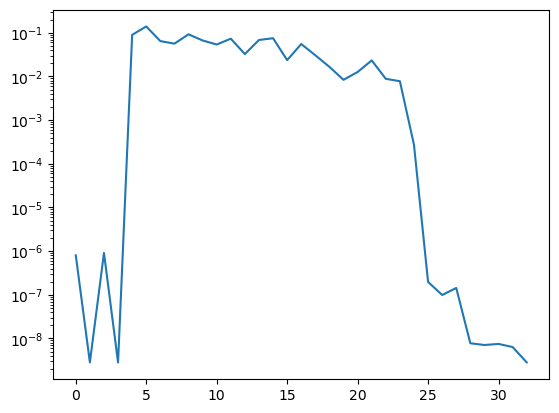

In [74]:
i = 596
plt.plot(prob[0, i, :])
plt.yscale('log')
torch.argmax(prob[0, i, :])

In [40]:
inv = {v:k for k,v in alphabet.tok_to_idx.items()}

In [41]:
inv

{0: '<cls>',
 1: '<pad>',
 2: '<eos>',
 3: '<unk>',
 4: 'L',
 5: 'A',
 6: 'G',
 7: 'V',
 8: 'S',
 9: 'E',
 10: 'R',
 11: 'T',
 12: 'I',
 13: 'D',
 14: 'P',
 15: 'K',
 16: 'Q',
 17: 'N',
 18: 'F',
 19: 'Y',
 20: 'M',
 21: 'H',
 22: 'W',
 23: 'C',
 24: 'X',
 25: 'B',
 26: 'U',
 27: 'Z',
 28: 'O',
 29: '.',
 30: '-',
 31: '<null_1>',
 32: '<mask>'}

In [47]:
torch.argmax(prob[0, T, :], dim=-1).numpy()

array([16, 11,  4,  9,  9,  5,  4,  9,  5,  5,  4,  4,  5,  5,  4,  4,  5,
        5,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  8,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5])

In [68]:
''.join([inv[i] for i in torch.argmax(prob[:,1:-1,:][0, T, :], dim=-1).numpy()])

'TLEEALEAALLAALLAALLAAAAAAAAAAAAAAAASAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'

In [69]:
protein.get_residues(T)

'GEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVP'

In [70]:
print(T)

[538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607]


In [71]:
select = [608,609,700,701,702,703,704,705]
print(protein.get_residues(select))
print(''.join([inv[i] for i in torch.argmax(prob[:,1:-1,:][0, select, :], dim=-1).numpy()]))

HRAVQQVV
HRAWQQVV


In [64]:
prob[:,1:-1,:].shape

torch.Size([1, 1103, 33])

In [60]:
len(protein.sequence)

1103